In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to read the HDF5 file
def read_hdf5_file_to_dict(filename):
    """
    Reads an HDF5 file and returns its contents as NumPy arrays in a dictionary.

    Parameters:
        filename (str): Path to the HDF5 file.

    Returns:
        dict: A dictionary containing the datasets read from the HDF5 file.
    """
    data_dict = {}
    with h5py.File(filename, 'r') as f:
        for key in ['parameters', 'sp_intensity', 'sp_no_lines_intensity']:
            data_dict[key] = np.array(f[key])
        data_dict["log10_sp_wave"] = np.array(f["log10_sp_wave"])
        data_dict["log10_sp_no_lines_wave"] = np.array(f["log10_sp_no_lines_wave"])
    return data_dict

# Read the HDF5 file
filename = '/scratch/y89/tr0953/korg_grid_calculation/ready_grids/regular_grid.h5'
data = read_hdf5_file_to_dict(filename)

# Extract the parameters
parameters = data['parameters']

df_params = pd.DataFrame({
    'Teff': parameters[:, 0],
    'logg': parameters[:, 1],
    '[M/H]': parameters[:, 2],
    'mu': parameters[:, 3]
})

In [2]:
from jax.scipy.interpolate import RegularGridInterpolator


In [3]:
# Create interpolator for each wavelength point
from tqdm import tqdm

wavelengths = data['log10_sp_wave'][::100]
    # Get intensity values for this wavelength
intensities = data['sp_intensity'][:, ::100]

# Create interpolator using parameters as points and intensities as values
# Extract unique parameter values for each dimension
teff_vals = np.unique(data['parameters'][:, 0])
logg_vals = np.unique(data['parameters'][:, 1]) 
mh_vals = np.unique(data['parameters'][:, 2])
alpha_vals = np.unique(data['parameters'][:, 3])

# Create interpolator with parameter grids
interp = RegularGridInterpolator((teff_vals, logg_vals, mh_vals, alpha_vals, wavelengths), 
                                intensities.reshape(len(teff_vals), len(logg_vals), 
                                                    len(mh_vals), len(alpha_vals), len(wavelengths)))


In [4]:
data['log10_sp_wave'][0]

3.669317400765426

In [5]:
import jax
import jax.numpy as jnp


interp(np.array([5000, 4.0, 1.0, 0.02, data['log10_sp_wave'][0]]))
interpolate_spectrum = jax.vmap(lambda p, w: interp(jnp.concatenate([p, jnp.array([w])])), in_axes=(None, 0))

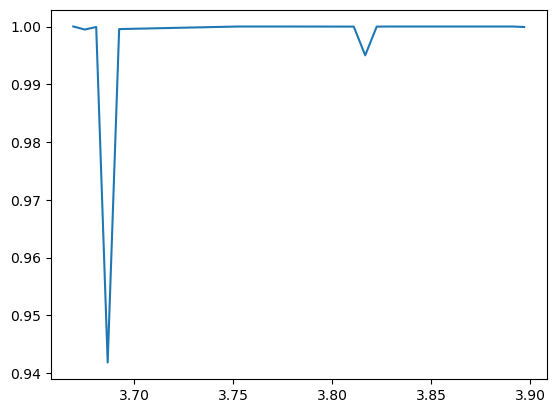

In [6]:
parameters = jnp.array([5000, 4.0, 1.0, 0.02])
spec = interpolate_spectrum(parameters, data['log10_sp_wave'][::4000])
plt.plot(data['log10_sp_wave'][::4000], spec)
plt.show()


In [7]:
np.unique(data['parameters'][:, 0])

array([4000., 4250., 4500., 4750., 5000., 5250., 5500., 5750., 6000.,
       6250., 6500., 6750., 7000., 7250., 7500., 7750., 8000.])

In [8]:
# Create a grid of points halfway between original grid points
import itertools

# Set JAX to use 64-bit precision
jax.config.update("jax_enable_x64", True)


wavelengths = data['log10_sp_wave'][::100]

# Extract unique parameter values for each dimension
teff_vals = np.unique(data['parameters'][:, 0])
logg_vals = np.unique(data['parameters'][:, 1]) 
mh_vals = np.unique(data['parameters'][:, 2])
alpha_vals = np.unique(data['parameters'][:, 3])

# Calculate midpoints between grid values
teff_mid = np.unique(teff_vals[:-1] + (teff_vals[1:] - teff_vals[:-1])/2)[::4]
logg_mid = np.unique(logg_vals[:-1] + (logg_vals[1:] - logg_vals[:-1])/2)[::2]
mh_mid = np.unique(mh_vals[:-1] + (mh_vals[1:] - mh_vals[:-1])/2)[::2]
alpha_mid = np.unique(alpha_vals[:-1] + (alpha_vals[1:] - alpha_vals[:-1])/2)[::4]

In [9]:
# Create all combinations of midpoints
mid_points = np.array(list(itertools.product(teff_mid, logg_mid, mh_mid, alpha_mid)))

# Interpolate spectra at midpoints using previously defined interpolator
mid_spectra = jnp.array([interpolate_spectrum(mid_points[i], wavelengths) for i in tqdm(range(len(mid_points)))])

mid_interp = RegularGridInterpolator((teff_mid, logg_mid, mh_mid, alpha_mid, wavelengths), 
                                    mid_spectra.reshape(len(teff_mid), len(logg_mid), len(mh_mid), len(alpha_mid), len(wavelengths)))
mid_interp_v = jax.vmap(lambda p, w: mid_interp(jnp.concatenate([p, jnp.array([w])])), in_axes=(None, 0))
# Get original grid points

100%|████████████████████████████████████████████████████████████████████████████████| 420/420 [03:30<00:00,  1.99it/s]


In [10]:
data['parameters'].shape

(35700, 4)

In [11]:
original_points = data['parameters'][::100]


# Interpolate original spectra at same wavelength points for comparison
original_spectra = [mid_interp_v(data['parameters'][i], wavelengths) for i in tqdm(range(len(data['parameters'][::100])))]


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [02:48<00:00,  2.12it/s]


In [12]:
original_spectra = np.array(original_spectra)
mid_spectra = np.array(mid_spectra)

In [16]:
original_spectra.shape

(357, 660, 1)

In [18]:
data['sp_intensity'][::100, ::100].shape

(357, 660)

RMS error from interpolation: 0.021813


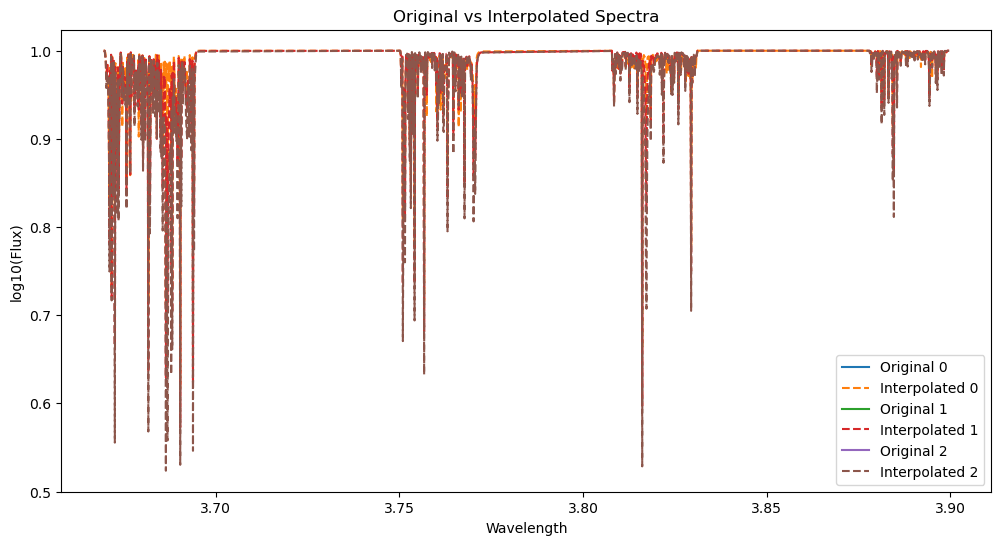

In [19]:
# Calculate RMS error between original and interpolated spectra
rms_error = np.nanmean((original_spectra[:, :, 0] - data['sp_intensity'][::100, ::100])**2)

print(f"RMS error from interpolation: {rms_error:.6f}")

# Plot a few example spectra to visualize differences
plt.figure(figsize=(12,6))
for i in range(3):  # Plot first 3 spectra
    plt.plot(wavelengths, original_spectra[i], label=f'Original {i}')
    plt.plot(wavelengths, mid_spectra[i], '--', label=f'Interpolated {i}')
plt.xlabel('Wavelength')
plt.ylabel('log10(Flux)')
plt.title('Original vs Interpolated Spectra')
plt.legend()
plt.show()

In [20]:
# Create dictionary with data to save
save_data = {
    'parameters': original_points,
    'original_spectra': original_spectra,
    'reconstructed_spectra': mid_spectra,
    'wavelengths': wavelengths,
    'rms_error': rms_error
}

# Save to HDF5 file
with h5py.File('spectra_comparison.h5', 'w') as f:
    for key, value in save_data.items():
        f.create_dataset(key, data=value)


Keys in loaded data: ['original_spectra', 'parameters', 'reconstructed_spectra', 'rms_error', 'wavelengths']

Shapes:
original_spectra: (357, 660, 1)
parameters: (357, 4)
reconstructed_spectra: (420, 660, 1)
rms_error: <class 'numpy.float64'>
wavelengths: (660,)

Loaded RMS error: 0.021813


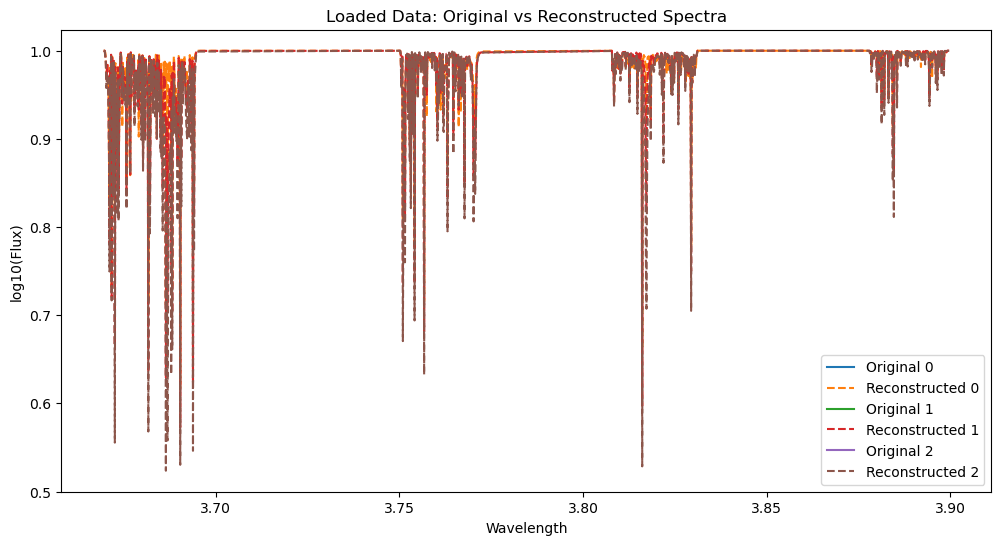

In [21]:
# Load and verify saved data
with h5py.File('spectra_comparison.h5', 'r') as f:
    loaded_data = {key: f[key][()] for key in f.keys()}

print("Keys in loaded data:", list(loaded_data.keys()))
print("\nShapes:")
for key, value in loaded_data.items():
    if isinstance(value, np.ndarray):
        print(f"{key}: {value.shape}")
    else:
        print(f"{key}: {type(value)}")

# Verify RMS error matches
print(f"\nLoaded RMS error: {loaded_data['rms_error']:.6f}")

# Plot a few loaded spectra to verify
plt.figure(figsize=(12,6))
for i in range(3):
    plt.plot(loaded_data['wavelengths'], loaded_data['original_spectra'][i], 
             label=f'Original {i}')
    plt.plot(loaded_data['wavelengths'], loaded_data['reconstructed_spectra'][i], 
             '--', label=f'Reconstructed {i}')
plt.xlabel('Wavelength')
plt.ylabel('log10(Flux)')
plt.title('Loaded Data: Original vs Reconstructed Spectra')
plt.legend()
plt.show()
